In [ ]:
!pip install optuna
!pip install scikit-optimize lightgbm catboost xgboost
!pip install dask[dataframe] -- upgrade
!pip install autogluon

ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)
ERROR: No matching distribution found for upgrade


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.samplers import TPESampler

from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.common import space

from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
from scipy.special import logit
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from autogluon.features.generators import AutoMLPipelineFeatureGenerator

from ray import tune
from imblearn.over_sampling import SMOTE


from sklearn.model_selection import cross_val_score, KFold
from skopt import BayesSearchCV

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Here is the differents steps :

- Loading of the data (the train and test table)
- Description of the tables
- Feature Engineering
- AutoGluon to find the best models
- Optuna to find the best hyperparameters

In [ ]:
## Settings to change

target = "loan_status"
time_limit_first_model = 60*1
time_limit_HP = 60*60
n_folds = 5
seed = 14*27*151

In [ ]:
## Import the data

train = pd.read_csv("/train.csv", sep=",",encoding="ISO-8859-1")
test = pd.read_csv("/test.csv", sep=",",encoding="ISO-8859-1")

In [ ]:
train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


Function :

Description of the table :

In [ ]:
train_encode = AutoMLPipelineFeatureGenerator().fit_transform(X=train)
test_encode = AutoMLPipelineFeatureGenerator().fit_transform(X=test)
train_encode.head()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,person_home_ownership,loan_intent,loan_grade
0,0,37,35000,0.0,6000,11.49,0.17,0,14,0,3,1,1
1,1,22,56000,6.0,4000,13.35,0.07,0,2,0,2,3,2
2,2,29,28800,8.0,6000,8.90,0.21,0,10,0,2,4,0
3,3,30,70000,14.0,12000,11.11,0.17,0,5,0,3,5,1
4,4,22,60000,2.0,6000,6.92,0.10,0,3,0,3,3,0


In [ ]:
sns.set_theme(style="darkgrid")
fig, axs = plt.subplots(2, 2, figsize=(4, 4))
sns.histplot(train_encode)

<Axes: ylabel='Count'>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


Error in callback <function flush_figures at 0x79b8eff7c280> (for post_execute):


KeyboardInterrupt: 

In [ ]:
##faire deux cate : les valeurs et les categories
##pour les valeurs, histogramme
##pour les categories, repartition selon la target

In [ ]:
train_encode.hist(figsize=(12, 10), color='skyblue', edgecolor='black')
plt.gcf().set_facecolor('#36454F')
plt.tight_layout()
plt.show()

KeyError: "['loan_status'] not found in axis"

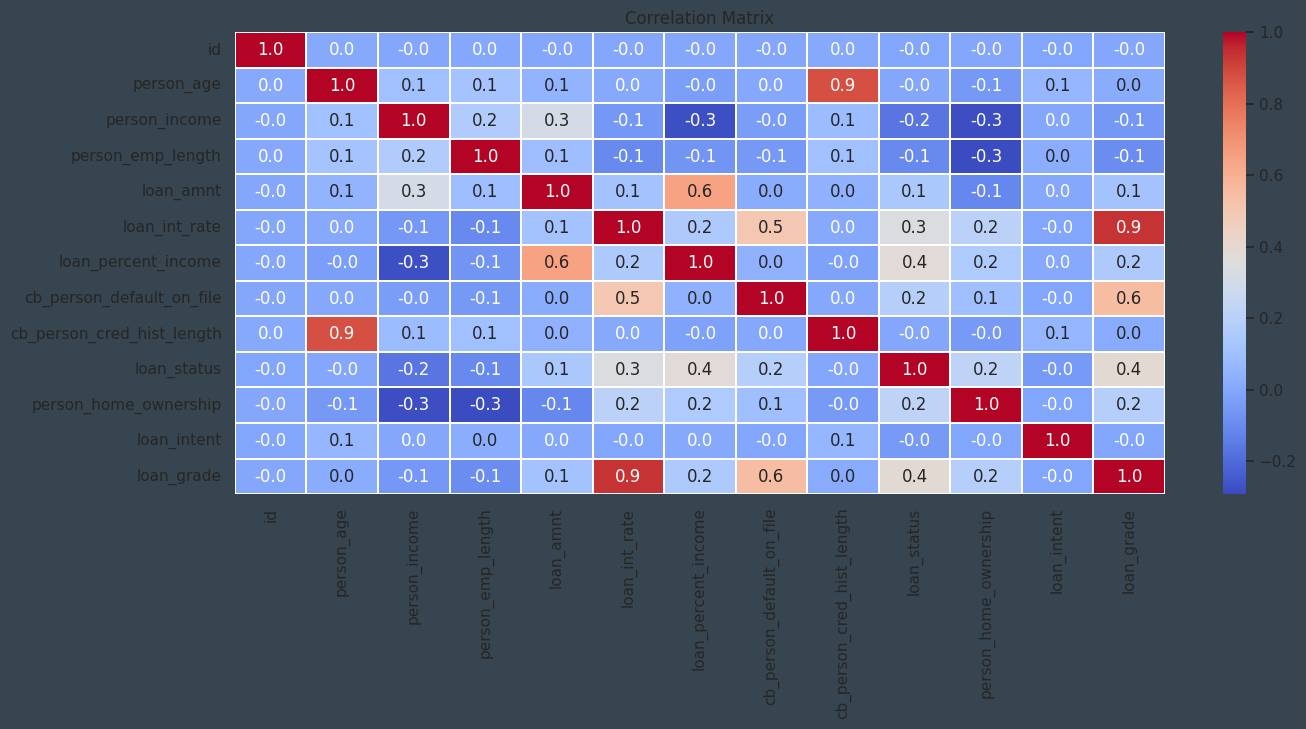

In [ ]:
correlation_matrix = train_encode.corr()
plt.figure(figsize=(15, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.2)
plt.gcf().set_facecolor('#36454F')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
correlation_matrix[target].sort_values(ascending=False)

,loan_status
loan_status,1.000000
loan_grade,0.385908
loan_percent_income,0.378280
loan_int_rate,0.338948
person_home_ownership,0.220167
cb_person_default_on_file,0.186962
loan_amnt,0.144982
person_age,-0.001130
cb_person_cred_hist_length,-0.003030
id,-0.008138


Feature engineering part :

In [ ]:
## Regarder les outliers pour chaque Loan Intent en terme de montant
## Voir si colinearite entre loan grade et les autres variables
## Checker en ligne pour voir les variables qui influent le plus
## Voir pour faire de l'oversampling si jamais il y a pas assez de 0 ou de 1

In [ ]:
variables_with_missing_values_50 = [
    var for var in train.columns if train[var].isnull().sum() > len(train)/2
]

train = train.drop(columns=variables_with_missing_values_50)
print(f"Variables with a lot of missing values: {variables_with_missing_values_50}")

# Find variables with missing values
variables_with_missing_values = [
    var for var in train.columns if train[var].isnull().sum() > 0
]

print(f"Variables with missing values: {variables_with_missing_values}")

Variables with a lot of missing values: []
Variables with missing values: []


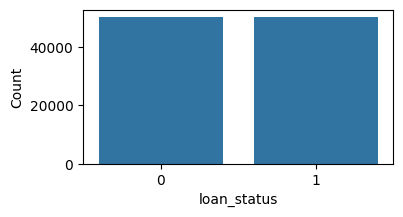

In [ ]:
## OverSampling the data if unbalanced :

plt.figure(figsize=(4, 2))
sns.countplot(x=target, data=train_encode)
plt.xlabel(target)
plt.ylabel('Count')
plt.show()

In [ ]:
run = 1

if run==1:
  # Apply SMOTE to the specified class
  smote = SMOTE(random_state=seed)
  X_resampled, y_resampled = smote.fit_resample(train_encode.drop(columns=target), train_encode[target])

  X_resampled_df = pd.DataFrame(X_resampled, columns=train_encode.drop(columns=target).columns)
  train_encode = pd.concat([X_resampled_df, y_resampled], axis=1)

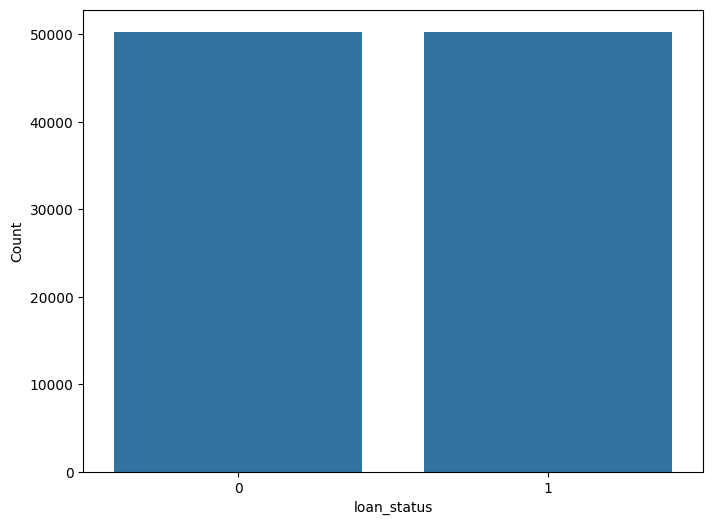

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x=target, data=train_encode)
plt.xlabel(target)
plt.ylabel('Count')
plt.show()

Choice of the model :

In [ ]:
## First, we will use AutoGluon to find the best models

predictor = TabularPredictor(label=target, eval_metric='roc_auc').fit(
    train_encode, time_limit=time_limit_first_model, presets='good_quality',num_gpus=1)

No path specified. Models will be saved in: "AutogluonModels/ag-20241025_110434"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       9.39 GB / 12.67 GB (74.1%)
Disk Space Avail:   66.07 GB / 107.72 GB (61.3%)
Presets specified: ['good_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~8x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data size.
	You can avoid this risk by setting `save_bag_folds=True`.
DyStack is enab

In [ ]:
#Here is the ones availables :
## https://auto.gluon.ai/dev/api/autogluon.tabular.models.html

##'NN_TORCH': Neural Network TensorFlow
##'GBM': GBM Model
##'CAT': Catboost
##'XGB': XGBoost
##'FASTAI': Neural Network for Tabular data
##'RF': Random Forest Model
##'XT': Extra Tree model
##'KNN' K Nearest Neighbors

In [ ]:
leaderboard = predictor.leaderboard(silent=True)
leaderboard

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT_BAG_L1,0.986898,roc_auc,1.068982,31.237909,1.068982,31.237909,1,False,1
1,WeightedEnsemble_L2,0.986898,roc_auc,1.093451,31.261280,0.024468,0.023371,2,False,2
2,WeightedEnsemble_L3,0.986898,roc_auc,1.101887,31.270166,0.032905,0.032257,3,False,3
3,WeightedEnsemble_L3_FULL,NaN,roc_auc,NaN,2.040729,NaN,0.032257,3,True,6
4,WeightedEnsemble_L2_FULL,NaN,roc_auc,NaN,2.031843,NaN,0.023371,2,True,5
5,LightGBMXT_BAG_L1_FULL,NaN,roc_auc,NaN,2.008472,NaN,2.008472,1,True,4


In [ ]:
 # Impute missing values (only for original dataset)

trainFT = train.copy()

categorical_columns = trainFT.select_dtypes(include=["object"]).columns.tolist()

# Convert categorical columns to 'category' type
trainFT[categorical_columns] = trainFT[categorical_columns].astype(str).astype("category")

encoder = OrdinalEncoder()
trainFT[categorical_columns] = encoder.fit_transform(trainFT[categorical_columns])

# Divide data into X and y sets
X = trainFT.drop(target, axis=1)
y = trainFT[target]

In [ ]:
# Define the search space for hyperparameters
search_spaces = {
    'GBM': {
        'learning_rate': (0.01, 0.3),
        'num_leaves': (31, 100),
        'min_child_samples': (1, 10),
        'max_depth': (1, 10)
    },
    'CAT': {
        'learning_rate': (0.01, 0.3),
        'depth': (1, 10),
        'l2_leaf_reg': (1, 10),
        'iterations': (100, 1000)
    },
    'XGB': {
        'learning_rate': (0.01, 0.3),
        'max_depth': (1, 10),
        'n_estimators': (100, 1000),
        'min_child_weight': (1, 10)
    }
}

# Define the models
models = {
    'GBM': LGBMClassifier(),
    'CAT': CatBoostClassifier(),
    'XGB': XGBClassifier()
}

# Define the cross-validation strategy
cv = StratifiedKFold(n_folds, shuffle=True,
                        random_state=seed)

dico = {}

# Define the search for the best hyperparameters
for model_name, model in models.items():
    search = BayesSearchCV(
        model,
        search_spaces[model_name],
        n_iter=10,
        cv=cv,
        random_state=seed
    )
    search.fit(X, y)
    dico[model_name] = search.best_params_



Streaming output truncated to the last 5000 lines.
3:	learn: 0.3763338	total: 22.4ms	remaining: 684ms
4:	learn: 0.3386179	total: 28.2ms	remaining: 682ms
5:	learn: 0.3095521	total: 33.8ms	remaining: 677ms
6:	learn: 0.2869016	total: 42.3ms	remaining: 720ms
7:	learn: 0.2689418	total: 54.5ms	remaining: 803ms
8:	learn: 0.2551105	total: 60.1ms	remaining: 782ms
9:	learn: 0.2441169	total: 65.6ms	remaining: 761ms
10:	learn: 0.2353721	total: 71.4ms	remaining: 747ms
11:	learn: 0.2274797	total: 77.5ms	remaining: 736ms
12:	learn: 0.2209186	total: 83.8ms	remaining: 729ms
13:	learn: 0.2163035	total: 89.5ms	remaining: 716ms
14:	learn: 0.2122472	total: 97.6ms	remaining: 722ms
15:	learn: 0.2084121	total: 110ms	remaining: 753ms
16:	learn: 0.2058177	total: 121ms	remaining: 775ms
17:	learn: 0.2033209	total: 127ms	remaining: 760ms
18:	learn: 0.2014609	total: 132ms	remaining: 745ms
19:	learn: 0.1995686	total: 138ms	remaining: 731ms
20:	learn: 0.1979821	total: 144ms	remaining: 721ms
21:	learn: 0.1965572	total

In [ ]:
## display the hyperparameters if you need to re-run it :

dico

{'GBM': OrderedDict([('learning_rate', 0.0787074981016308),
              ('max_depth', 8),
              ('min_child_samples', 8),
              ('num_leaves', 58)]),
 'CAT': OrderedDict([('depth', 10),
              ('iterations', 967),
              ('l2_leaf_reg', 9),
              ('learning_rate', 0.01935011258954552)]),
 'XGB': OrderedDict([('learning_rate', 0.0787074981016308),
              ('max_depth', 8),
              ('min_child_weight', 8),
              ('n_estimators', 451)])}

In [ ]:
hyperparameters = {

                   ##LightBGM
                  'GBM':{'learning_rate': 0.08556786152814144,
                  'max_depth': 11, 'n_estimators': 1130,
                  'max_leaf_nodes': 90,
                  'min_samples_split': 0.11732169002596993,
                  'min_weight_fraction_leaf': 0.0014666658781746856,
                  'subsample': 0.9514006946730825,
                  'random_state':seed},
                  ##XGBoost
                   'XGB':{'reg_lambda': 1.450818947592862,
                          'gamma': 1.2989545549241457,
                          'reg_alpha': 2.399943704514481,
                          'learning_rate': 0.06427113988108137,
                          'max_depth': 4, 'min_child_weight': 29,
                          'subsample': 0.8785131663693533,
                          'colsample_bytree': 0.7645812462563925,
                          'n_estimators': 734,
                          'scale_pos_weight': 4.7403114041039025,
                          'random_state':seed}
                    }

hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'num_trials': 5,
    'scheduler' : 'local',
    'searcher': 'auto',
}


## 'NN_TORCH':{'num_epochs': 10,
##                   'learning_rate': space.Real(1e-4, 1e-2, default=5e-4, log=True),
##                   'activation': space.Categorical('relu', 'softrelu', 'tanh'),
##                   'dropout_prob': space.Real(0.0, 0.5, default=0.1),},

## chelou j'avais mis ca pour XGboost
##{'reg_lambda': 1.450818947592862, 'gamma': 1.2989545549241461, 'reg_alpha': 2.399943704514481, 'learning_rate': 0.06427113988108137, 'max_depth': 4, 'min_child_weight': 29, 'subsample': 0.8785131663693533, 'colsample_bytree': 0.7645812462563925, 'n_estimators': 734, 'scale_pos_weight': 4.7403114041039025}

In [ ]:
predictor_ensemble = TabularPredictor(label=target, eval_metric='roc_auc').fit(
    train_encode, time_limit=time_limit_HP, presets='best_quality', hyperparameters=dico,
    num_bag_folds=5, num_stack_levels=2, num_gpus=1)

leaderboard = predictor_ensemble.leaderboard(silent=True)

No path specified. Models will be saved in: "AutogluonModels/ag-20241025_112341"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       9.34 GB / 12.67 GB (73.7%)
Disk Space Avail:   66.06 GB / 107.72 GB (61.3%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=2, num_bag_folds=5, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be 

In [ ]:
top_models = list(leaderboard['model'].head(3))

for model in top_models:
  predictor_ensemble.refit_full(model=model)

top_models

Refitting models via `predictor.refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix "_FULL" and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `predictor.fit` call.
	To learn more, refer to the `.refit_full` method docstring which explains how "_FULL" models differ from normal models.
Fitting 1 L1 models ...
Fitting model: LightGBM_BAG_L1_FULL ...
	3.31s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: XGBoost_BAG_L1_FULL ...
	4.91s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: CatBoost_BAG_L1_FULL ...
	212.95s	 = Training   runtime
Fitting 1 L2 models ...
Fitting model: CatBoost_BAG_L2_FULL ...
	105.82s	 = Training   runtime
Fitting 1 L2 models ...
Fitting model: XGBoost_BAG_L2_FULL ...
	3.66s	 = Training   runtime
Fitting 1 L2 models ...
Fitting model: LightGBM_BAG_L2_FULL ...
	2.39s	 = Training   runtime
Fitting 1 L3 models ..

['WeightedEnsemble_L4', 'WeightedEnsemble_L2', 'WeightedEnsemble_L3']

In [ ]:
## lAST MODEL, the one to predict them all

predictions = predictor_ensemble.predict(test_encode)
predictions

,loan_status
0,1
1,0
2,1
3,0
4,0
...,...
39093,0
39094,0
39095,0
39096,0


In [ ]:
submissions = pd.DataFrame({
    'id' : test['id'],
    'loan_status' : predictions
})

submissions.to_csv('/submission.csv', index=False)

In [ ]:
predictor_ensemble.feature_importance(train)

Computing feature importance via permutation shuffling for 12 features using 5000 rows with 5 shuffle sets...
	22.76s	= Expected runtime (4.55s per shuffle set)
	15.56s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
person_income,0.248771,0.006804,6.709218e-08,5,0.262781,0.234761
loan_percent_income,0.063973,0.003103,6.625759e-07,5,0.070363,0.057583
loan_int_rate,0.051155,0.007228,4.658912e-05,5,0.066038,0.036272
loan_amnt,0.041037,0.003539,6.570836e-06,5,0.048324,0.033751
id,0.025219,0.002998,2.352128e-05,5,0.031392,0.019046
person_age,0.017139,0.002725,7.412892e-05,5,0.022749,0.011529
person_emp_length,0.014173,0.003080,2.515820e-04,5,0.020515,0.007831
cb_person_cred_hist_length,0.011896,0.001991,9.064218e-05,5,0.015995,0.007798
person_home_ownership,0.000000,0.000000,5.000000e-01,5,0.000000,0.000000
loan_intent,0.000000,0.000000,5.000000e-01,5,0.000000,0.000000
